# TCC Strictu Sensu - Skin Cancer detector

## 1. Definição do Problema
*Porque?* 
Cancer de pele é um dos cancer mais comuns na atualidade, se identificado no inicio, pode ser mais fácilmente tratado. A concientização é muito importante, devemos informar a população de modo geral e facilitar o teste, como por exemplo um simples carregar de uma foto em um aplicativo que já te retornará as chances de ser uma pinta ou mancha na pele se desenvolver em um cancer de pele.

*Quem?* 
Este projeto visa ajudar todos que tiverem acesso a internet, ou smartphones, provendo uma maneira fácil de avaliar se pintas ou manchas na pele podem ser um cancer de pele em estágio inicial

*Oque?*
Um modelo de machine learning(mais precisamente deep learninng) que permitará que usuários externos testem pintas ou manchas, buscando por possiveis cancer de pele.

*Quando?*
O modelo deverá responder de maneira instantanea, ou mais próxima ao tempo real como 1 a 5 minutos. 

*Onde?*
A principio através de input manual nesse projeto, mas no futuro usuários poderão carregar e testar imagens por um site ou applicativo de Smartphone.

## 2. Coleta dos Dados
Segundo os requisitos desse projeto, duas bases de dados são requeridas. O tema desse projeto tem sido muito trabalhado por vários projetos ao longo dos últimos anos, porém existem apenas algumas bases muito populares, praticamente todas providas pela mesma fonte a ISIC que anualmente (desde 2016) tem lançado um desafio de Machine Learning e providenciado datasets com milhares de imagens com este tema. Entretando como exigência do projeto tive de buscar uma base de dados distinta e após pesquisa encontrei um dataset pequeno mas que me fornece imagens de Nevuas normais e melanoma. Afim de unir as bases precisei reduzir o escopo do dataset provido pela HAM10000 (Imagens colhidas pela ISIC em 2018), em apenas Nevuas normais ou melanomas.

In [56]:
import pandas as pd
import shutil
import os

In [55]:
final_path = "dataset_final//imagens//"

In [57]:
path_HAM10000 = "dataset_1//HAM10000_images//"
df_HAM10000_csv = "dataset_1//HAM10000_metadata"

df_HAM10000_csv = pd.read_csv(df_HAM10000_csv)

#Tamanho original
print('Tamanho Original: ', df_HAM10000_csv.shape)

#Filtrando apenas melanocytic nevi (begnigno) e melanoma(maligno), 
#o resto da base será desconsiderado para este estudo.
df_HAM10000_csv_filtered=df_HAM10000_csv[(df_HAM10000_csv.dx == "nv") | (df_HAM10000_csv.dx == "mel")]

#Tamanho após filtrado
print('Tamanho após aplifcar o filtro: ', df_HAM10000_csv_filtered.shape)

#Movendo os arquivos para Pasta Final
for index, row in df_HAM10000_csv_filtered.iterrows(): 
    shutil.copy2(path_HAM10000 + row['image_id'] + '.jpg', final_path)


Tamanho Original:  (10015, 8)
Tamanho após aplifcar o filtro:  (7818, 8)


In [90]:
df_mednode = pd.DataFrame(columns=['image_id','type'])
path_mednode = "dataset_2//complete_mednode_dataset//"

for diretorio,subpasta, arquivos in os.walk(path_mednode):
    if diretorio !="dataset_2//complete_mednode_dataset//":
        for arquivo in arquivos:
            if 'melanoma' in diretorio:
                df_mednode=df_mednode.append({'image_id': arquivo.replace('.jpg',''), 'type':'mel'}, ignore_index=True)
                shutil.copy2(diretorio +'//'+ arquivo, final_path)
            elif 'naevus' in diretorio:
                df_mednode=df_mednode.append({'image_id': arquivo.replace('.jpg',''), 'type':'nv'}, ignore_index=True)
                shutil.copy2(diretorio +'//'+ arquivo, final_path)
        
print(df_mednode.shape)
df_mednode.head()

(170, 2)


image_id type
0    2216854  mel
1    1834988  mel
2   512681-h  mel
3  2234484-h  mel
4     625759  mel

In [108]:
#Unindo os dataframes de Typagem de cada imagem:

print('Dataframe HAM10000: ', df_HAM10000_csv_filtered.shape)
print('Dataframe HAM10000 colunas: ', df_HAM10000_csv_filtered.columns)

print('Dataframe Med Node: ', df_mednode.shape)
print('Dataframe Med Node colunas: ', df_mednode.columns)

df_HAM10000_final=df_HAM10000_csv_filtered.drop(columns=['lesion_id', 'dx_type', 'age', 'sex', 'localization', 'dataset'])
df_HAM10000_final=df_HAM10000_final.rename(columns = {'image_id': 'image_id', 'dx': 'type'}, inplace = False)

df_final = pd.DataFrame(columns=['image_id','type'])
df_final = df_final.append(df_HAM10000_final, ignore_index=True)
df_final = df_final.append(df_mednode, ignore_index=True)

print('Dataframe final: ' , df_final.shape)

print(df_final.head())
print(df_final.tail())

df_final.to_csv("dataset_final//" + "classificacao_dataset.csv")

Dataframe HAM10000:  (7818, 8)
Dataframe HAM10000 colunas:  Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset'],
      dtype='object')
Dataframe Med Node:  (170, 2)
Dataframe Med Node colunas:  Index(['image_id', 'type'], dtype='object')
Dataframe final:  (7988, 2)
       image_id type
0  ISIC_0024698   nv
1  ISIC_0024693   nv
2  ISIC_0025964  mel
3  ISIC_0030623  mel
4  ISIC_0027190  mel
       image_id type
7983  2202309-h   nv
7984    2215612   nv
7985    2085285   nv
7986   416266-h   nv
7987     457838   nv


## 3. Processamento/Tratamento dos Dados


In [5]:
import albumentations as alb
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
!cd dataset_final/imagens/ && ls

132357.jpg       ISIC_0026677.jpg ISIC_0029252.jpg ISIC_0031838.jpg
136733.jpg       ISIC_0026678.jpg ISIC_0029253.jpg ISIC_0031839.jpg
151560-h.jpg     ISIC_0026680.jpg ISIC_0029254.jpg ISIC_0031840.jpg
154372.jpg       ISIC_0026681.jpg ISIC_0029255.jpg ISIC_0031841.jpg
156136.jpg       ISIC_0026682.jpg ISIC_0029256.jpg ISIC_0031842.jpg
159033.jpg       ISIC_0026683.jpg ISIC_0029257.jpg ISIC_0031843.jpg
16175.jpg        ISIC_0026684.jpg ISIC_0029258.jpg ISIC_0031844.jpg
162029.jpg       ISIC_0026685.jpg ISIC_0029259.jpg ISIC_0031845.jpg
163067.jpg       ISIC_0026686.jpg ISIC_0029261.jpg ISIC_0031846.jpg
165021.jpg       ISIC_0026688.jpg ISIC_0029262.jpg ISIC_0031847.jpg
1651872.jpg      ISIC_0026689.jpg ISIC_0029264.jpg ISIC_0031848.jpg
1657793.jpg      ISIC_0026690.jpg ISIC_0029265.jpg ISIC_0031849.jpg
1685446.jpg      ISIC_0026691.jpg ISIC_0029266.jpg ISIC_0031850.jpg
1697738.jpg      ISIC_0026692.jpg ISIC_0029267.jpg ISIC_0031854.jpg
1698285.jpg      ISIC_0026694.jpg ISIC_0029269.j

In [7]:
imagens = []
for arquivo in os.listdir(final_path):
  img = cv2.imread(os.path.join(final_path,arquivo))
  if img is not None:
    imagens.append(img)

In [8]:
print('Quantidade de Imagens: ', len(imagens))

Quantidade de Imagens:  7988


Imagem: 1
largura: 450, altura: 600, canal: 3


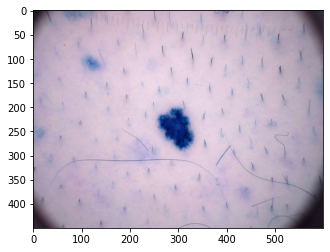

Imagem: 2
largura: 450, altura: 600, canal: 3


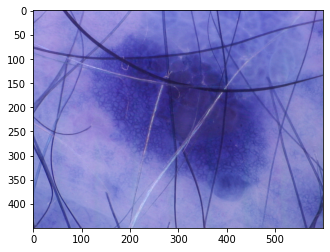

Imagem: 3
largura: 450, altura: 600, canal: 3


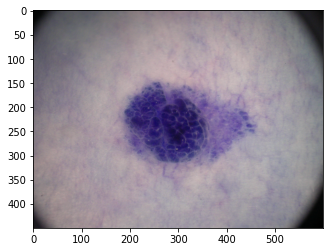

Imagem: 4
largura: 450, altura: 600, canal: 3


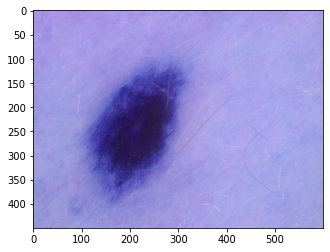

Imagem: 5
largura: 450, altura: 600, canal: 3


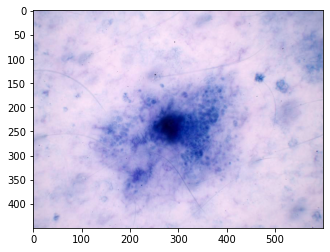

Imagem: 6
largura: 450, altura: 600, canal: 3


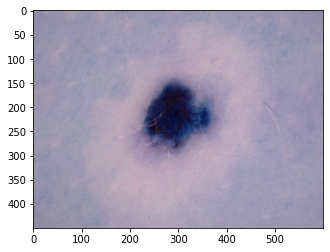

Imagem: 7
largura: 450, altura: 600, canal: 3


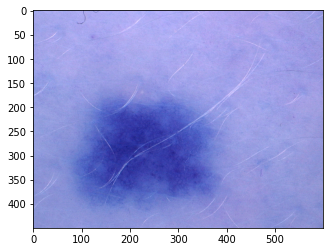

Imagem: 8
largura: 450, altura: 600, canal: 3


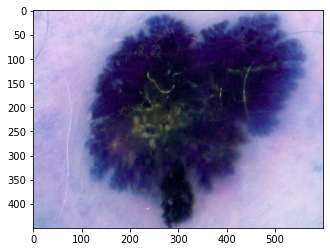

Imagem: 9
largura: 450, altura: 600, canal: 3


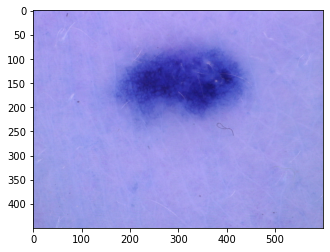

Imagem: 10
largura: 450, altura: 600, canal: 3


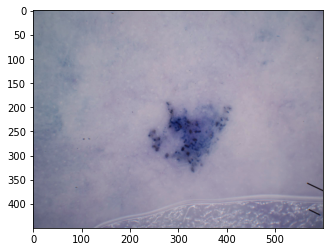

In [9]:
altura=[]
largura=[]
canal=[]
  
for i in range(10):
  print("Imagem:",i+1)
  x,y,z=imagens[i].shape
  largura.append(x)
  altura.append(y)
  canal.append(z)
  print('largura: ' + str(x) + ', altura: ' + str(y) + ', canal: '+ str(z))
  plt.imshow(imagens[i])
  plt.show()

## 4. Análise/Exploração dos Dados



In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [8]:
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

In [9]:
!pwd

/Users/cesaraugustosiqueirasantos/Documents/POS/tcc_pos


In [10]:
pele_df = pd.read_csv('dataset_final/classificacao_dataset.csv')
print(pele_df.head())
np.random.seed(42)

SIZE=64

   Unnamed: 0      image_id type
0           0  ISIC_0024698   nv
1           1  ISIC_0024693   nv
2           2  ISIC_0025964  mel
3           3  ISIC_0030623  mel
4           4  ISIC_0027190  mel


In [11]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(pele_df['type'])
LabelEncoder()
print(list(le.classes_))

pele_df['label'] = le.transform(pele_df["type"]) 
print(pele_df.sample(10))


['mel', 'nv']
      Unnamed: 0      image_id type  label
2748        2748  ISIC_0032502   nv      1
5583        5583  ISIC_0033857   nv      1
2572        2572  ISIC_0030863   nv      1
1954        1954  ISIC_0030461   nv      1
4727        4727  ISIC_0032262   nv      1
1615        1615  ISIC_0027661   nv      1
7927        7927        411966   nv      1
1018        1018  ISIC_0030083  mel      0
7052        7052  ISIC_0027255   nv      1
3441        3441  ISIC_0024354   nv      1


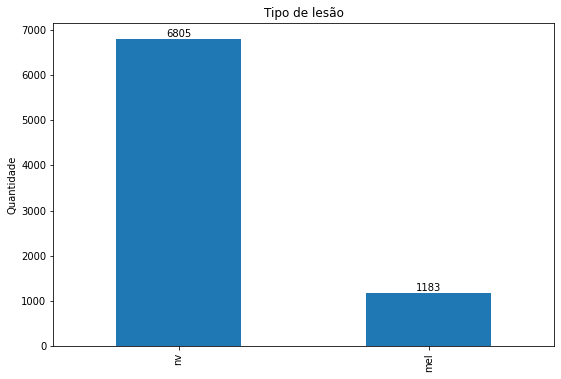

1    6805
0    1183
Name: label, dtype: int64


In [12]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
pele_df['type'].value_counts().plot(kind='bar', ax=ax)
ax.set_ylabel('Quantidade')
ax.set_title('Tipo de lesão');
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

print(pele_df['label'].value_counts())

In [13]:
#Distribution of data into various classes 
from sklearn.utils import resample

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = pele_df[pele_df['label'] == 0]
df_1 = pele_df[pele_df['label'] == 1]


n_samples=1500
df_mel_balanceado = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_nv_balanceado = resample(df_1, replace=True, n_samples=n_samples, random_state=42)

pele_df_balanceado = pd.concat([df_mel_balanceado, df_nv_balanceado])


#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(pele_df_balanceado['label'].value_counts())

0    1500
1    1500
Name: label, dtype: int64


In [14]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('dataset_final', '*', '*.jpg'))}
#Define the path and add as a new column
pele_df_balanceado['path'] = pele_df['image_id'].map(image_path.get)
#Use the path to read images.
pele_df_balanceado['imagem'] = pele_df_balanceado['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

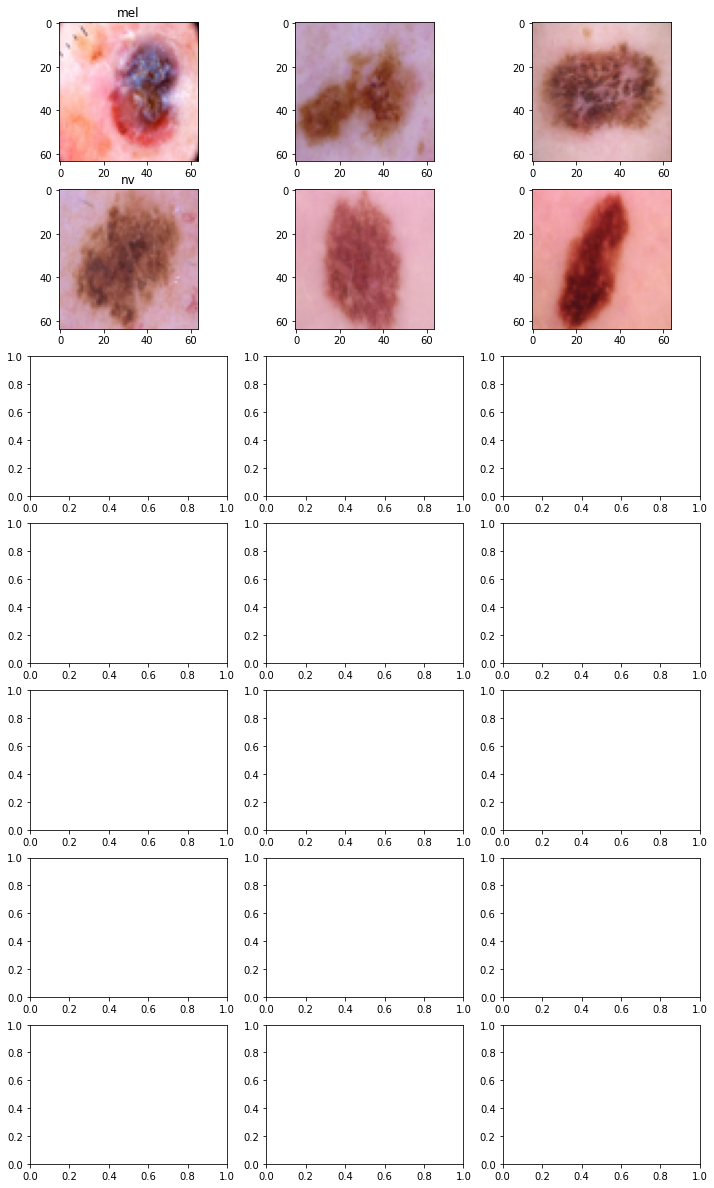

In [16]:
num_exemplos = 3  

# Plot
fig, m_axs = plt.subplots(7, num_exemplos, figsize = (4*num_exemplos, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         pele_df_balanceado.sort_values(['type']).groupby('type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(num_exemplos, random_state=1234).iterrows()):
        c_ax.imshow(c_row['imagem'])
        c_ax.axis('off')


In [17]:
#Convert dataframe column of images into numpy array
X = np.asarray(pele_df_balanceado['imagem'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=pele_df_balanceado['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
print('X: ', X)
print('Y: ', Y)

X:  [[[[0.85490196 0.56078431 0.40784314]
   [0.85490196 0.56862745 0.42745098]
   [0.85490196 0.58039216 0.44705882]
   ...
   [0.8627451  0.59607843 0.44313725]
   [0.85882353 0.6        0.43921569]
   [0.86666667 0.62745098 0.49803922]]

  [[0.85098039 0.56470588 0.41568627]
   [0.8627451  0.58823529 0.45490196]
   [0.85490196 0.58039216 0.43137255]
   ...
   [0.8627451  0.59607843 0.43921569]
   [0.85882353 0.60784314 0.4627451 ]
   [0.87058824 0.62352941 0.50196078]]

  [[0.85882353 0.58431373 0.42745098]
   [0.85882353 0.59215686 0.43921569]
   [0.8627451  0.59607843 0.43529412]
   ...
   [0.85882353 0.60784314 0.46666667]
   [0.8627451  0.61176471 0.4745098 ]
   [0.8627451  0.61176471 0.48235294]]

  ...

  [[0.85098039 0.58431373 0.43921569]
   [0.85882353 0.58823529 0.45490196]
   [0.86666667 0.60784314 0.48235294]
   ...
   [0.83921569 0.57647059 0.43137255]
   [0.85490196 0.6        0.46666667]
   [0.84313725 0.58823529 0.44313725]]

  [[0.85882353 0.60784314 0.48235294]
   

In [18]:
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.90, random_state=42)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [21]:
datagen.fit(x_train_auto)

In [22]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(64,64,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 


2022-03-08 22:09:56.653375: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 8, 64)          0         
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
          

In [24]:
 from tensorflow.keras.optimizers import Adam

In [27]:
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])


In [28]:
history = model.fit(x_train_auto,y_train_auto,epochs = 500 , validation_data = (x_test_auto, y_test_auto))

Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 667, in start
      self.io_loop.start()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 345, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/n0/r90d5h151sq9vq_khl6kf7v40000gn/T/ipykernel_89805/2540296181.py", line 1, in <module>
      history = model.fit(x_train_auto,y_train_auto,epochs = 500 , validation_data = (x_test_auto, y_test_auto))
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,2] and labels shape [224]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_911]

In [41]:
num_output_classes = 2 # 0 = mel, 1 = nv
input_img_size = (64, 64, 3)  # 64x64 image with 3 color channel

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_img_size))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_output_classes, activation="softmax"))
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adadelta(),
    metrics=["accuracy"],
)

In [42]:
batch_size = 128
epochs = 100

history  = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)

Epoch 1/100
19/19 [==============================] - 31s 2s/step - loss: 0.6706 - accuracy: 0.6162 - val_loss: 0.8806 - val_accuracy: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 31s 2s/step - loss: 0.6718 - accuracy: 0.6204 - val_loss: 0.8993 - val_accuracy: 0.0000e+00
Epoch 3/100
19/19 [==============================] - 31s 2s/step - loss: 0.6683 - accuracy: 0.6204 - val_loss: 0.9160 - val_accuracy: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 33s 2s/step - loss: 0.6655 - accuracy: 0.6233 - val_loss: 0.9313 - val_accuracy: 0.0000e+00
Epoch 5/100
19/19 [==============================] - 30s 2s/step - loss: 0.6679 - accuracy: 0.6246 - val_loss: 0.9201 - val_accuracy: 0.0000e+00
Epoch 6/100
19/19 [==============================] - 30s 2s/step - loss: 0.6663 - accuracy: 0.6254 - val_loss: 0.9137 - val_accuracy: 0.0000e+00
Epoch 7/100
19/19 [==============================] - 34s 2s/step - loss: 0.6643 - accuracy: 0.6225 - val_loss: 0.9197 - val_accura

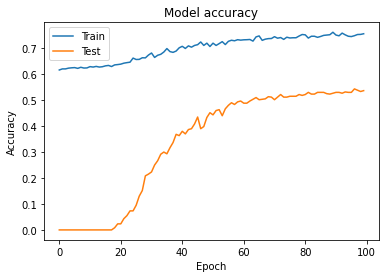

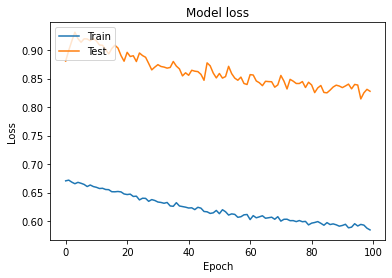

In [43]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [44]:
model.evaluate(X[-300:],Y[-300:])

10/10 [==============================] - 1s 129ms/step - loss: 0.8203 - accuracy: 0.5667


[0.8202874064445496, 0.5666666626930237]

In [47]:
Y_pred = model.predict(X)

yd = Y_pred[:, 1] - Y_pred[:, 0]

most_mel = np.argsort(yd)
most_nv = np.argsort(yd)[::-1]
most_ambiguous = np.argsort(np.abs(yd))

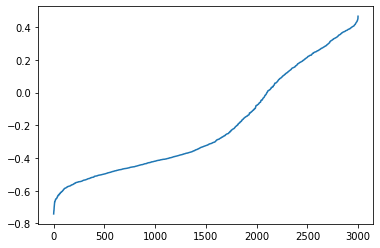

In [46]:
plt.plot(np.sort(yd))

In [58]:
files = ["{}/{}".format(final_path, fi) for fi in os.listdir(final_path) if fi.endswith("jpg")][:2000]

In [62]:
def get_image_data(filename):
    img = Image.open(filename)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data
    
def plot_5(indices, savename=None):
    f, axarr = plt.subplots(5, 5)
    f.set_size_inches(12, 12)
    f.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    for i in range(5):
        axarr[i // 5, i % 5].axis("off")
        axarr[i // 5, i % 5].imshow(get_image_data(files[indices[i]]))
    if savename is not None:
        f.savefig(savename)

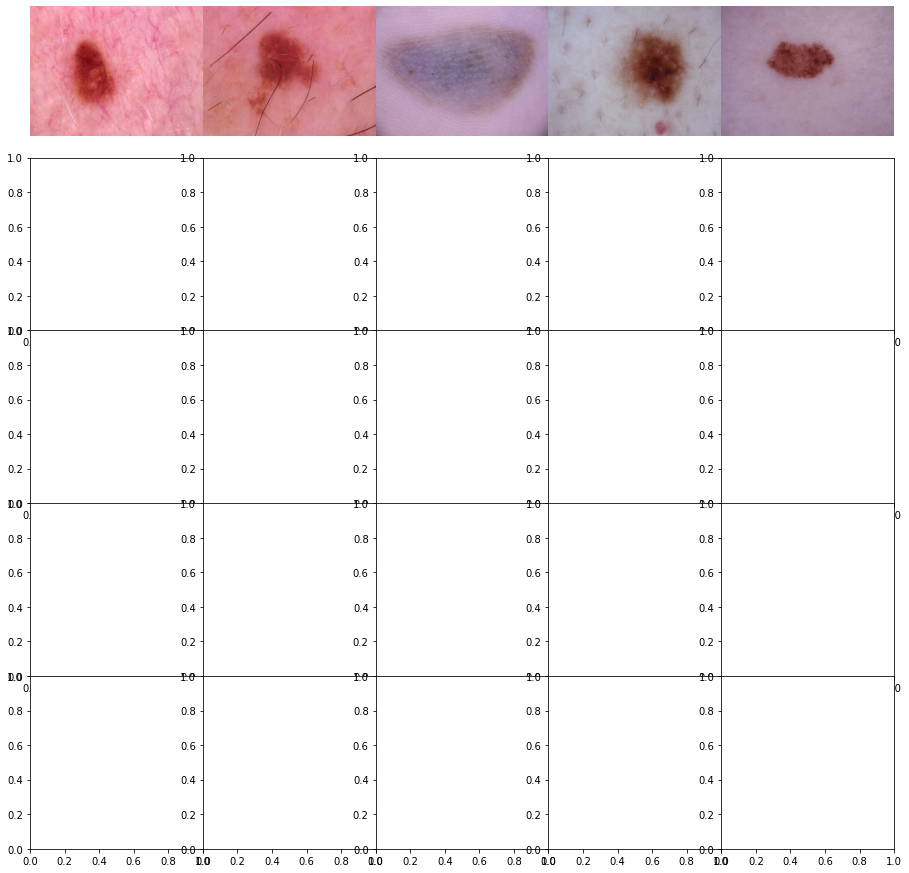

In [63]:
plot_5(most_mel[:5], "./most_mel.jpg")

IndexError: list index out of range

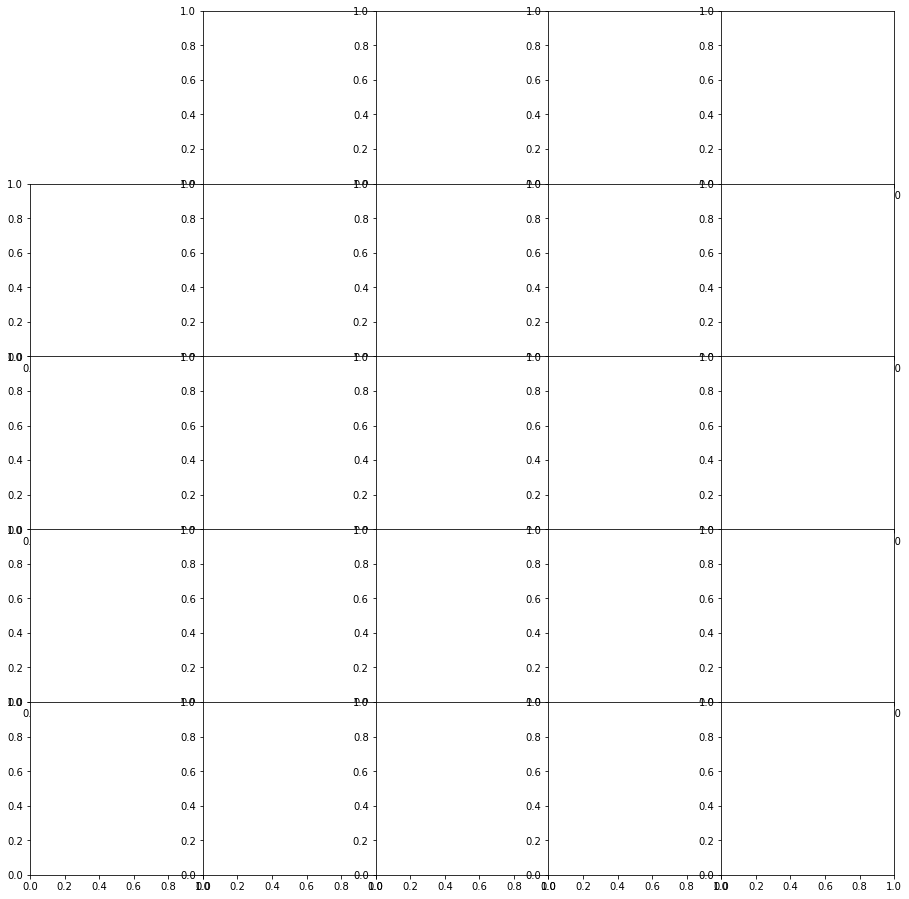

In [64]:
plot_5(most_nv[:5], "./most_nv.jpg")

IndexError: list index out of range

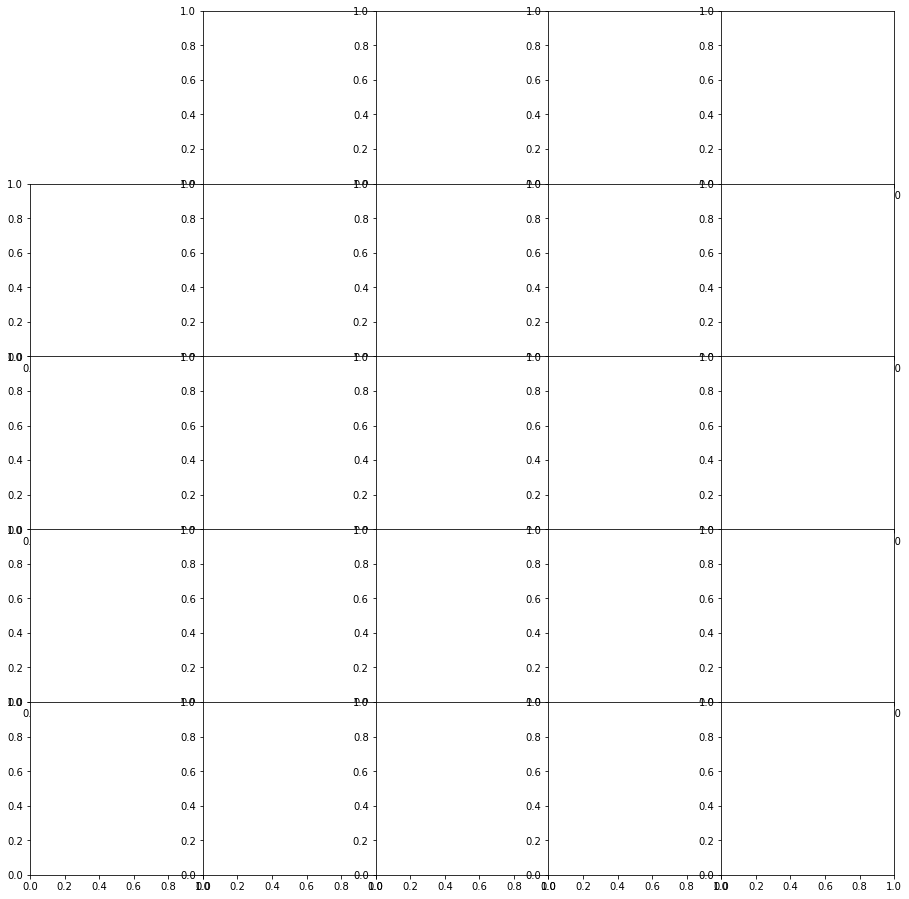

In [65]:
plot_5(most_ambiguous[:5], "./most_ambiguous_1.jpg")
plot_5(most_ambiguous[5:15], "./most_ambiguous_2.jpg")
plot_5(most_ambiguous[15:20], "./most_ambiguous_3.jpg")

In [59]:
#Further split data into smaller size to get a small test dataset. 
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.10, random_state=42)

In [63]:
#Define classifier for autokeras. Here we check 25 different models, each model 25 epochs
clf = ak.ImageClassifier(max_trials=2) #MaxTrials - max. number of keras models to try
clf.fit(x_train_auto, y_train_auto, epochs=2)

INFO:tensorflow:Reloading Oracle from existing project ./image_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
image_block_1/b...|efficient         |vanilla           
image_block_1/n...|True              |True              
image_block_1/a...|True              |False             
image_block_1/i...|True              |None              
image_block_1/i...|False             |None              
image_block_1/i...|0                 |None              
image_block_1/i...|0                 |None              
image_block_1/i...|0.1               |None              
image_block_1/i...|0                 |None              
image_block_1/e...|True              |None              
image_block_1/e...|b7                |None              
image_block_1/e...|True              |None              
image_block_1/e...|True              |None              
classification_...|gl

Exception: URL fetch failure on https://storage.googleapis.com/keras-applications/efficientnetb7_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)

In [62]:
#Evaluate the classifier on test data
_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", (acc * 100.0), "%")

NotFoundError: ./image_classifier/best_pipeline; No such file or directory

In [ ]:
# get the final best performing model
model = clf.export_model()
print(model.summary())

In [ ]:
#Save the model
model.save('cifar_model.h5')

In [ ]:
score = model.evaluate(x_valid, y_valid)
print('Test accuracy:', score[1])

## 5. Criação do Modelo de ML

## 6. Interpretação dos Resultados

## 7. Comunicação dos Resultados

## 8. Referencias
Tschandl, Philipp, 2018, "The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions", https://doi.org/10.7910/DVN/DBW86T, Harvard Dataverse, V3, UNF:6:/APKSsDGVDhwPBWzsStU5A== [fileUNF]

I. Giotis, N. Molders, S. Land, M. Biehl, M.F. Jonkman and N. Petkov: "MED-NODE: A computer-assisted melanoma diagnosis system using non-dermoscopic images", Expert Systems with Applications, 42 (2015), 6578-6585 

Skin cancer detection: Applying a deep learning based model driven architecture in the cloud for classifying dermal cell images | https://www.sciencedirect.com/science/article/pii/S2352914819302047

PH2 dataset | https://www.fc.up.pt/addi/ph2%20database.html


Aprendizagem Profunda Aplicada a Identificação de melanoma | https://tedebc.ufma.br/jspui/bitstream/tede/2578/2/LucasMaia.pdf

Github Project - Skin Cancer detection |
https://github.com/Tirth27/Skin-Cancer-Classification-using-Deep-Learning

Good keras gudie | https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

MACHINE LEARNING WITH PYTHON: TRAIN YOUR OWN IMAGE CLASSIFICATION MODEL WITH KERAS AND TENSORFLOW | https://mlconference.ai/blog/machine-learning-with-python/

Single Label Imagem Classification | https://blog.workaround.vercel.app/blog/single-label-image-classification-with-keras